In [79]:
# Imports
from mne.io.snirf import read_raw_snirf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.cross_decomposition import PLSRegression
from scipy.signal import butter, lfilter, freqz
import warnings
warnings.filterwarnings('ignore')

## Loading Data Sets

In [2]:
# Reading the data files
path_to_snirf = "f096049-Hb_Moments.snirf" #Patient 1 Run 1 data
path_to_snirf_1 = "1745f1d-Hb_Moments.snirf" #Patient 1 Run 2 data
path_to_snirf_2 = "157dcb4-Hb_Moments.snirf" #Patient 2 data
snirf = read_raw_snirf(path_to_snirf)
snirf_1 = read_raw_snirf(path_to_snirf_1)
snirf_2 = read_raw_snirf(path_to_snirf_2)

Loading /Users/soulaimanebentaleb/mne-python/f096049-Hb_Moments.snirf
Loading /Users/soulaimanebentaleb/mne-python/1745f1d-Hb_Moments.snirf
Loading /Users/soulaimanebentaleb/mne-python/157dcb4-Hb_Moments.snirf


In [3]:
# Obtaining NIRS data
data = snirf.get_data()
data_1 = snirf_1.get_data()
data_2 = snirf_2.get_data()

In [4]:
# Obtaining channels' names and locations
channel_names = [x['ch_name'] for x in snirf.info['chs']] #Patient 1 Run 1 channel names
channel_names_1 = [x['ch_name'] for x in snirf_1.info['chs']] #Patient 1 Run 2 channel names
channel_names_2 = [x['ch_name'] for x in snirf_2.info['chs']] #Patient 2 channel names

channel_locations_3d = [x['loc'][:3] for x in snirf.info['chs']] 
channel_locations_3d_1 = [x['loc'][:3] for x in snirf_1.info['chs']] 
channel_locations_3d_2 = [x['loc'][:3] for x in snirf_2.info['chs']] 

assert len(channel_names)==len(channel_locations_3d)

In [5]:
#Channel labels array: each element is 'True' if channel is Hbo or 'False' if it is HbR
is_hbo = np.array([1 if channel_name.endswith('hbo') else 0 for channel_name in channel_names], dtype=bool)
is_hbo_1 = np.array([1 if channel_name_1.endswith('hbo') else 0 for channel_name_1 in channel_names_1], dtype=bool)
is_hbo_2 = np.array([1 if channel_name_2.endswith('hbo') else 0 for channel_name_2 in channel_names_2], dtype=bool)

In [15]:
#Patient 1 Run 1 number of channels
print('For patient 1 run 1, there are '+str(len(data[is_hbo, :]))+' channels. Each channel outputs HbO data (Oxygenated Hemoglobin) and HbR data (Deoxygenated Hemoglobin).')

For patient 1 run 1, there are 2206 channels. Each channel outputs HbO data (Oxygenated Hemoglobin) and HbR data (Deoxygenated Hemoglobin).


In [17]:
#Patient 2 number of channels
print('For patient 2, there are '+str(len(data_2[is_hbo, :]))+' channels. Each channel outputs HbO data (Oxygenated Hemoglobin) and HbR data (Deoxygenated Hemoglobin).')

For patient 2, there are 2206 channels. Each channel outputs HbO data (Oxygenated Hemoglobin) and HbR data (Deoxygenated Hemoglobin).


## Raw Data Plotting

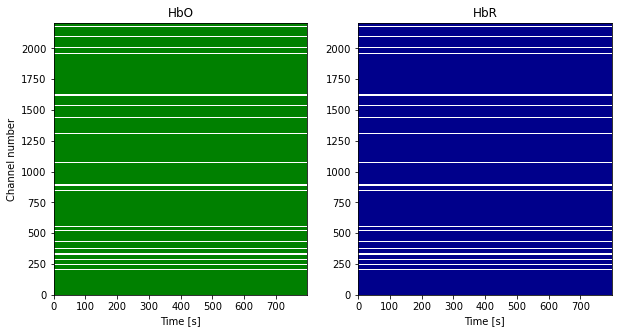

In [7]:
# Plotting raw data from patient 1 run 1
_, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].pcolor(snirf.times, np.arange(np.sum(is_hbo)), data[is_hbo, :], shading='nearest', color='green')
ax[0].set_title('HbO')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Channel number')
ax[1].pcolor(snirf.times, np.arange(np.sum(~is_hbo)), data[~is_hbo, :], shading='nearest', color='darkblue')
ax[1].set_title('HbR')
ax[1].set_xlabel('Time [s]')
plt.show() 

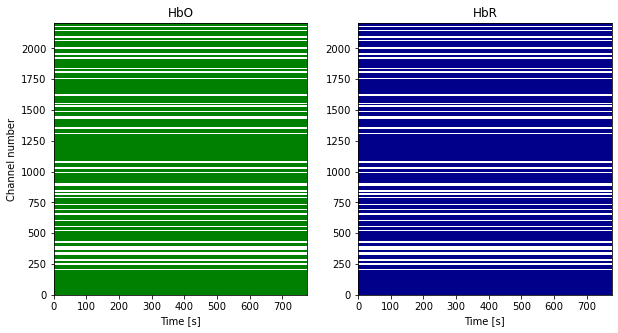

In [8]:
# Plotting raw data from patient 2
_, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].pcolor(snirf_2.times, np.arange(np.sum(is_hbo_2)), data_2[is_hbo_2, :], shading='nearest', color='green')
ax[0].set_title('HbO')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Channel number')
ax[1].pcolor(snirf_2.times, np.arange(np.sum(~is_hbo_2)), data_2[~is_hbo_2, :], shading='nearest', color='darkblue')
ax[1].set_title('HbR')
ax[1].set_xlabel('Time [s]')
plt.show() 

In [19]:
#A channel without data for patient 1 run 1 and patient 1
print(data[is_hbo, :][2000])
print(data_2[is_hbo, :][2000])

[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]


We can see on the plots above that some channels do not have any data, such as channel 2000. Let's remove all of these channels from our data arrays.

## Data Preprocessing

#### Souli's code

In [10]:
#Creating array that has the indices of the channels without data
nan_index=[]
for i in range(len(data)):
    if np.isnan(data[i][0])==True:
            nan_index.append(i)
            
nan_index_1=[]
for i in range(len(data_1)):
    if np.isnan(data_1[i][0])==True:
            nan_index_1.append(i)
    
nan_index_2=[]
for i in range(len(data_2)):
    if np.isnan(data_2[i][0])==True:
            nan_index_2.append(i)

In [11]:
#Creating data array that only has channels with data
real_data=np.delete(data, nan_index, 0)
real_data_1=np.delete(data_1, nan_index_1, 0)
real_data_2=np.delete(data_2, nan_index_2, 0)

#Creating channel label array that only has channels with data
real_is_hbo=np.delete(is_hbo, nan_index, 0)
real_is_hbo_1=np.delete(is_hbo_1, nan_index_1, 0)
real_is_hbo_2=np.delete(is_hbo_2, nan_index_2, 0)

assert len(real_data)==len(data)-len(nan_index)
assert len(real_data)==len(is_hbo)-len(nan_index)
assert len(real_data)==len(real_is_hbo)

In [21]:
#Checking that our new data arrays have no NaN elements
for i in range(len(real_data)):
    assert np.isnan(real_data[i][0])==False
    
for i in range(len(real_data_2)):
    assert np.isnan(real_data_2[i][0])==False

In [28]:
#Patient 1 Run 1 number of channels with data
print('For patient 1 run 1, only '+str(len(real_data[real_is_hbo, :]))+' channels actually carry data.')

For patient 1 run 1, only 1145 channels actually carry data.


In [30]:
#Patient 2 number of channels with data
print('For patient 2, only '+str(len(real_data_2[real_is_hbo_2, :]))+' channels actually carry data.')

For patient 2, only 666 channels actually carry data.


In [31]:
#Creating HbO data and HbR data arrays
hbo_data=real_data[real_is_hbo, :]
hbo_data_1=real_data_1[real_is_hbo_1, :]
hbo_data_2=real_data_2[real_is_hbo_2, :]

hbr_data=real_data[~real_is_hbo, :]
hbr_data_1=real_data_1[~real_is_hbo_1, :]
hbr_data_2=real_data_2[~real_is_hbo_2, :]

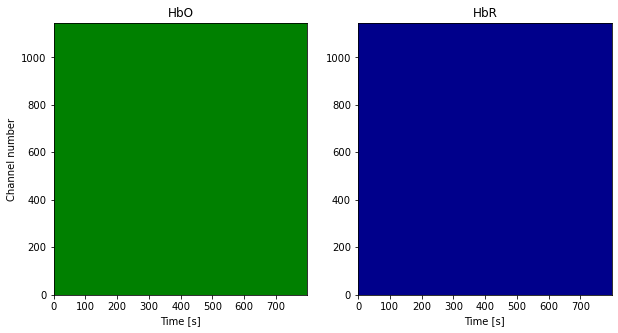

In [32]:
# Plotting preprocessed data from patient 1 run 1
_, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].pcolor(snirf.times, np.arange(np.sum(real_is_hbo)), hbo_data, shading='nearest', color='green')
ax[0].set_title('HbO')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Channel number')
ax[1].pcolor(snirf.times, np.arange(np.sum(~real_is_hbo)), hbr_data, shading='nearest', color='darkblue')
ax[1].set_title('HbR')
ax[1].set_xlabel('Time [s]')
plt.show() 

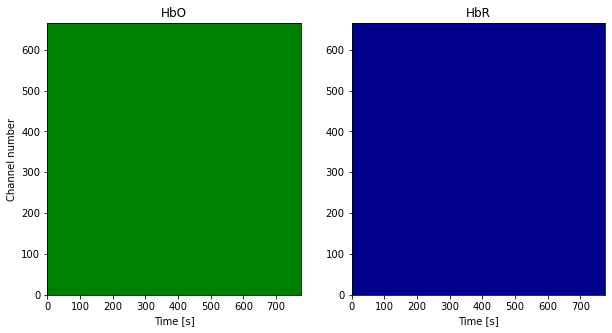

In [33]:
# Plotting preprocessed data from patient 2
_, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].pcolor(snirf_2.times, np.arange(np.sum(real_is_hbo_2)), hbo_data_2, shading='nearest', color='green')
ax[0].set_title('HbO')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Channel number')
ax[1].pcolor(snirf_2.times, np.arange(np.sum(~real_is_hbo_2)), hbr_data_2, shading='nearest', color='darkblue')
ax[1].set_title('HbR')
ax[1].set_xlabel('Time [s]')
plt.show() 

This again confirms that we successfully removed all of the channels that didn't output any data.

## Labels Setup

#### Souli's code

In [34]:
#Reading event task files
task_events_df = pd.read_csv('f096049_task_events.tsv', sep='\t') #Patient 1 Run 1 task events
task_events_df_1 = pd.read_csv('1745f1d_task_events.tsv', sep='\t') #Patient 1 Run 2 task events
task_events_df_2 = pd.read_csv('157dcb4_task_events.tsv', sep='\t') #Patient 2 task events

#Printing task events dataframe for Patient 1 Run 1 
print(task_events_df)

      timestamp             event    duration experiment_type  block  \
0      0.000000  start_experiment  789.392488  finger_tapping    NaN   
1      0.089842        start_rest   20.018517  finger_tapping    NaN   
2     20.108440       start_block   17.714409  finger_tapping    1.0   
3     20.156964         start_ITI    0.513069  finger_tapping    1.0   
4     20.670118       start_trial    0.806002  finger_tapping    1.0   
..          ...               ...         ...             ...    ...   
577  766.298867       start_trial    0.791355  finger_tapping   20.0   
578  767.139773         start_ITI    0.752528  finger_tapping   20.0   
579  767.892369       start_trial    0.802379  finger_tapping   20.0   
580  768.739782         start_ITI    0.567454  finger_tapping   20.0   
581  769.374845        start_rest   20.017540  finger_tapping    NaN   

    block_type  trial trial_type  
0          NaN    NaN        NaN  
1          NaN    NaN        NaN  
2        right    NaN        N

In [35]:
# Labels Array for Patient 1 Run 1 data
blocks_labels=np.empty(snirf.times.size) #5653 #This is a 0 (right-tapping block) or 1 (left-tapping block) array
rest_index=[]

for i in range(len(snirf.times)): #0 to 5653   
    #Right Ranges
    if snirf.times[i,] >=20.1084403991699 and snirf.times[i,] < 37.2906377315521:
        blocks_labels[i]=0
    elif snirf.times[i,] >=96.0085089206695 and snirf.times[i,] <115.45904135704:
        blocks_labels[i]=0
    elif snirf.times[i,] >=215.648464679718 and snirf.times[i,] <233.39488863945:
        blocks_labels[i]=0
    elif snirf.times[i,] >=254.080522060394 and snirf.times[i,] <270.762350082397:
        blocks_labels[i]=0
    elif snirf.times[i,] >=329.180588245391 and snirf.times[i,] <347.297376155853:
        blocks_labels[i]=0
    elif snirf.times[i,] >=407.016450643539 and snirf.times[i,] <423.932327508926:
        blocks_labels[i]=0
    elif snirf.times[i,] >=521.084533214569 and snirf.times[i,] <538.435498714447:
        blocks_labels[i]=0
    elif snirf.times[i,] >=597.4884724617 and snirf.times[i,] <615.069853544235:
        blocks_labels[i]=0
    elif snirf.times[i,] >=673.024507522583 and snirf.times[i,] <691.171491146087:
        blocks_labels[i]=0
    elif snirf.times[i,] >=750.456876039505 and snirf.times[i,] <768.739782094955:
        blocks_labels[i]=0

    #Left Ranges
    elif snirf.times[i,] >=57.9085166454315 and snirf.times[i,] <75.3247609138488:
        blocks_labels[i]=1
    elif snirf.times[i,] >=136.044531583786 and snirf.times[i,] <155.393176078796:
        blocks_labels[i]=1
    elif snirf.times[i,] >=176.312454462051 and snirf.times[i,] <194.860765457153:
        blocks_labels[i]=1
    elif snirf.times[i,] >=291.416473150253 and snirf.times[i,] <308.596531152725:
        blocks_labels[i]=1
    elif snirf.times[i,] >=368.048515081405 and snirf.times[i,] <386.398197889328:
        blocks_labels[i]=1
    elif snirf.times[i,] >=444.316514968872 and snirf.times[i,] <462.033178329467:
        blocks_labels[i]=1
    elif snirf.times[i,] >=482.384647130966 and snirf.times[i,] <500.434092283248:
        blocks_labels[i]=1
    elif snirf.times[i,] >=558.784443378448 and snirf.times[i,] <576.868988275528:
        blocks_labels[i]=1
    elif snirf.times[i,] >=635.356453895568 and snirf.times[i,] <651.970604419708:
        blocks_labels[i]=1
    elif snirf.times[i,] >=711.756521224975 and snirf.times[i,] <729.5390236377:
        blocks_labels[i]=1
    else: 
        blocks_labels[i]=2
        rest_index.append(i)

In [36]:
# Labels Array for Patient 2 data
blocks_labels_2=np.empty(snirf_2.times.size) #This is a 0 (right-tapping block) or 1 (left-tapping block) array of length 5493, which is the number of timestamps
rest_index_2=[]

for i in range(len(snirf_2.times)): #0 to 5493 
    #Right Ranges
    if snirf_2.times[i,] >=20.0404598712921 and snirf_2.times[i,] <=36.7387335300445 :
        blocks_labels_2[i]=0
    elif snirf_2.times[i,] >=95.0564653873443 and snirf_2.times[i,] <=110.852770090103:
        blocks_labels_2[i]=0
    elif snirf_2.times[i,] >=168.936528921127 and snirf_2.times[i,] <=185.850895881652:
        blocks_labels_2[i]=0
    elif snirf_2.times[i,] >=280.968475580215 and snirf_2.times[i,] <=297.413870334625:
        blocks_labels_2[i]=0
    elif snirf_2.times[i,] >=355.496618986129 and snirf_2.times[i,] <=373.029193162918:
        blocks_labels_2[i]=0
    elif snirf_2.times[i,] >=393.532568216323 and snirf_2.times[i,] <=410.99533867836:
        blocks_labels_2[i]=0
    elif snirf_2.times[i,] >=505.112452745437 and snirf_2.times[i,] <=521.557640314102:
        blocks_labels_2[i]=0
    elif snirf_2.times[i,] >=578.59243941307 and snirf_2.times[i,] <=595.454669713974:
        blocks_labels_2[i]=0
    elif snirf_2.times[i,] >=653.588501691818 and snirf_2.times[i,] <=670.286049604415:
        blocks_labels_2[i]=0
    elif snirf_2.times[i,] >=690.87249302864 and snirf_2.times[i,] <=707.718648910522:
        blocks_labels_2[i]=0

    #Left Ranges
    elif snirf_2.times[i,] >=57.5405182838439 and snirf_2.times[i,] <=74.6882479190826:
        blocks_labels_2[i]=1
    elif snirf_2.times[i,] >=131.9044659137726 and snirf_2.times[i,] <=148.735503435134:
        blocks_labels_2[i]=1
    elif snirf_2.times[i,] >=206.252545595169 and snirf_2.times[i,] <=223.566793203353:
        blocks_labels_2[i]=1
    elif snirf_2.times[i,] >=244.204538106918 and snirf_2.times[i,] <=260.23189663887:
        blocks_labels_2[i]=1
    elif snirf_2.times[i,] >=317.669047117233 and snirf_2.times[i,] <=334.762775421142:
        blocks_labels_2[i]=1
    elif snirf_2.times[i,] >=431.196606874465 and snirf_2.times[i,] <=447.677822351455:
        blocks_labels_2[i]=1
    elif snirf_2.times[i,] >=468.0444419384 and snirf_2.times[i,] <=484.558886051178:
        blocks_labels_2[i]=1
    elif snirf_2.times[i,] >=541.976702928543 and snirf_2.times[i,] <=558.139090299606:
        blocks_labels_2[i]=1
    elif snirf_2.times[i,] >=616.340427160263 and snirf_2.times[i,] <=632.904483795166:
        blocks_labels_2[i]=1
    elif snirf_2.times[i,] >=727.96843957901 and snirf_2.times[i,] <=745.050502777099:
        blocks_labels_2[i]=1
    else: 
        blocks_labels_2[i]=2
        rest_index_2.append(i)

In [37]:
#Patient 1 Run 1
#Creating array of data only from left and right tapping blocks
right_left_data=np.delete(real_data, rest_index, 1)

#Creating array of data only from left and right tapping blocks
right_left_labels=np.delete(blocks_labels, rest_index)

assert len(blocks_labels)-len(rest_index)==len(right_left_labels)
assert len(right_left_labels)==len(right_left_data[0])

In [38]:
#Repeat for Patient 2
right_left_data_2=np.delete(real_data_2, rest_index_2, 1)

right_left_labels_2=np.delete(blocks_labels_2, rest_index_2)

assert len(blocks_labels_2)-len(rest_index_2)==len(right_left_labels_2)
assert len(right_left_labels_2)==len(right_left_data_2[0])

In [42]:
#Patient 1 Run 1, number of data points per channel
print('For patient 1 run 1, each channel now has '+str(len(right_left_labels))+' data points.')

For patient 1 run 1, each channel now has 2523 data points.


Each channel now has 2523 data points for patient 1 run 1.

In [43]:
#Patient 2, number of data points per channel
print('For patient 2, each channel now has '+str(len(right_left_labels_2))+' data points.')

For patient 2, each channel now has 2373 data points.


#### Sara's code

In [ ]:
df = pd.read_excel (r'/Users/sarabadih/Desktop/f096049_task_events.xlsx', sheet_name='f096049_task_events')
display(df)

#Extract the timestamp and block_type columns
time_stamps=df["timestamp"] #582 timestamps
block_type=df["block_type"]

In [50]:
#Defining moving average function
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    return np.convolve(np.squeeze(values), weights, 'valid')

In [51]:
# Labels Array for Training Datatset
avg=movingaverage(snirf.times,100)
blocks=np.empty(avg.size) #5554 #This is a 0 or 1 array representing the y_train

for i in range(len(avg)): #0 to 5554   
    #Right Ranges
    if avg[i,] >=20.1084403991699 and avg[i,] <= 37.2906377315521:
        blocks[i]=0
    elif avg[i,] >=96.0085089206695 and avg[i,] <= 115.45904135704:
        blocks[i]=0
    elif avg[i,] >=215.648464679718 and avg[i,] <=233.39488863945:
        blocks[i]=0
    elif avg[i,] >=254.080522060394 and avg[i,] <=270.762350082397:
        blocks[i]=0
    elif avg[i,] >=329.180588245391 and avg[i,] <=347.297376155853:
        blocks[i]=0
    elif avg[i,] >=407.016450643539 and avg[i,] <=423.932327508926:
        blocks[i]=0
    elif avg[i,] >=521.084533214569 and avg[i,] <=538.435498714447:
        blocks[i]=0
    elif avg[i,] >=597.4884724617 and avg[i,] <=615.069853544235:
        blocks[i]=0
    elif avg[i,] >=673.024507522583 and avg[i,] <=691.171491146087:
        blocks[i]=0
    elif avg[i,] >=750.456876039505 and avg[i,] <=768.739782094955:
        blocks[i]=0

    #Left Ranges
    elif avg[i,] >=57.9085166454315 and avg[i,] <= 75.3247609138488:
        blocks[i]=1
    elif avg[i,] >=136.044531583786 and avg[i,] <= 155.393176078796:
        blocks[i]=1
    elif avg[i,] >=176.312454462051 and avg[i,] <= 194.860765457153:
        blocks[i]=1
    elif avg[i,] >=291.416473150253 and avg[i,] <=308.596531152725:
        blocks[i]=1
    elif avg[i,] >=368.048515081405 and avg[i,] <=386.398197889328:
        blocks[i]=1
    elif avg[i,] >=444.316514968872 and avg[i,] <=462.033178329467:
        blocks[i]=1
    elif avg[i,] >=482.384647130966 and avg[i,] <=500.434092283248:
        blocks[i]=1
    elif avg[i,] >=558.784443378448 and avg[i,] <=576.868988275528:
        blocks[i]=1
    elif avg[i,] >=635.356453895568 and avg[i,] <=651.970604419708:
        blocks[i]=1
    elif avg[i,] >=711.756521224975 and avg[i,] <=729.5390236377:
        blocks[i]=1
    else: 
        blocks[i]=0 #What do i set my nan to
#Assertions 
assert(blocks[4988]==1.0)
assert(blocks[93]==0.0)
assert(blocks[0]==0.0)
assert(blocks.shape==(5554,))

In [52]:
#Read in Test DataSet
path = "157dcb4-Hb_Moments.snirf" #Patient 1 Run 1 data
snirf_test = read_raw_snirf(path)

#Labels Array for Test Dataset
avg=movingaverage(snirf_test.times,100)
y_test=np.empty(avg.size) #5394 #This is a 0,1 array representing the y_test

for i in range(len(avg)): #0 to 5394 
    #Right Ranges
    if avg[i,] >=20.0404598712921 and avg[i,] <=36.7387335300445 :
        y_test[i]=0
    elif avg[i,] >=95.0564653873443 and avg[i,] <=110.852770090103:
        y_test[i]=0
    elif avg[i,] >=168.936528921127 and avg[i,] <=185.850895881652:
        y_test[i]=0
    elif avg[i,] >=280.968475580215 and avg[i,] <=297.413870334625:
        y_test[i]=0
    elif avg[i,] >=355.496618986129 and avg[i,] <=373.029193162918:
        y_test[i]=0
    elif avg[i,] >=393.532568216323 and avg[i,] <=410.99533867836:
        y_test[i]=0
    elif avg[i,] >=505.112452745437 and avg[i,] <=521.557640314102:
        y_test[i]=0
    elif avg[i,] >=578.59243941307 and avg[i,] <=595.454669713974:
        y_test[i]=0
    elif avg[i,] >=653.588501691818 and avg[i,] <=670.286049604415:
        y_test[i]=0
    elif avg[i,] >=690.87249302864 and avg[i,] <=707.718648910522:
        y_test[i]=0

    #Left Ranges
    elif avg[i,] >=57.5405182838439 and avg[i,] <=74.6882479190826:
        y_test[i]=1
    elif avg[i,] >=131.9044659137726 and avg[i,] <=148.735503435134:
        y_test[i]=1
    elif avg[i,] >=206.252545595169 and avg[i,] <=223.566793203353:
        y_test[i]=1
    elif avg[i,] >=244.204538106918 and avg[i,] <=260.23189663887:
        y_test[i]=1
    elif avg[i,] >=317.669047117233 and avg[i,] <=334.762775421142:
        y_test[i]=1
    elif avg[i,] >=431.196606874465 and avg[i,] <=447.677822351455:
        y_test[i]=1
    elif avg[i,] >=468.0444419384 and avg[i,] <=484.558886051178:
        y_test[i]=1
    elif avg[i,] >=541.976702928543 and avg[i,] <=558.139090299606:
        y_test[i]=1
    elif avg[i,] >=616.340427160263 and avg[i,] <=632.904483795166:
        y_test[i]=1
    elif avg[i,] >=727.96843957901 and avg[i,] <=745.050502777099:
        y_test[i]=1
    else: 
        y_test[i]=0 #What do i set my nan to

Loading /Users/soulaimanebentaleb/mne-python/157dcb4-Hb_Moments.snirf


## Data Processing

#### Souli's code

In [53]:
#Patient 1 Run 1
#Creating an array of the moving average of the data from right and left blocks
avg_right_left_data=[np.empty(movingaverage(right_left_data[0], 100).shape)]

for i in range(len(right_left_data)):
    avg_right_left_data=np.append(avg_right_left_data,[movingaverage(right_left_data[i], 100).tolist()],axis=0)
    
avg_right_left_data=np.delete(avg_right_left_data, 0, 0)

assert len(avg_right_left_data)==len(right_left_data)

In [54]:
#Repeat for Patient 2
avg_right_left_data_2=[np.empty(movingaverage(right_left_data_2[0], 100).shape)]

for i in range(len(right_left_data_2)):
    avg_right_left_data_2=np.append(avg_right_left_data_2,[movingaverage(right_left_data_2[i], 100).tolist()],axis=0)
    
avg_right_left_data_2=np.delete(avg_right_left_data_2, 0, 0)

assert len(avg_right_left_data_2)==len(right_left_data_2)

In [55]:
#Patient 1 Run 1
#Creating an array of the moving average of the labels for right and left blocks
avg_right_left_labels=movingaverage(right_left_labels, 100)

assert len(avg_right_left_labels)==len(avg_right_left_data[0])

In [56]:
#Repeat for Patient 2
avg_right_left_labels_2=movingaverage(right_left_labels_2, 100)

assert len(avg_right_left_labels_2)==len(avg_right_left_data_2[0])

In [57]:
#Patient 1 Run 1
#Printing number of data points per channel
len(avg_right_left_labels)

2424

In [58]:
#Repeat for Patient 2
len(avg_right_left_labels_2)

2274

In [59]:
#Patient 1 Run 1
#Showing that labels array has values different than 0 or 1
avg_right_left_labels[100]

0.79

In [60]:
#Repeat for Patient 2
avg_right_left_labels_2[100]

0.81

Each channel now has 2424 data points for patient 1 and 2274 for patient 2. However, our labels array now has averaged values that are neither 0 nor 1 but all of these values are greater than 0 and less than 0. Therefore, let's fix this by having all values greaer than or equal to 0.5 be 1 and all values less than 0.5 be 0.

In [61]:
#Patient 1 Run 1
#Creating label array of size 2274 with labels 0 (right-tapping) or 1 (left-tapping)
filt_right_left_labels=np.array([])

for i in avg_right_left_labels:
    if i>=0.5:
        filt_right_left_labels=np.append(filt_right_left_labels,1)
    else:
        filt_right_left_labels=np.append(filt_right_left_labels,0)
        
assert len(filt_right_left_labels)==len(avg_right_left_labels)

In [62]:
#Repeat for Patient 2
filt_right_left_labels_2=np.array([])

for i in avg_right_left_labels_2:
    if i>=0.5:
        filt_right_left_labels_2=np.append(filt_right_left_labels_2,1)
    else:
        filt_right_left_labels_2=np.append(filt_right_left_labels_2,0)
        
assert len(filt_right_left_labels_2)==len(avg_right_left_labels_2)

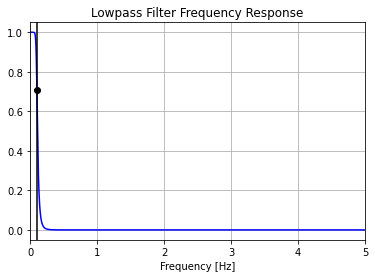

In [63]:
#Low Pass Filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Setting standard filter requirements.
order = 6
fs = 10   #This is the sampling rate I derived from the cutoff frequency they used(0.1=Fs/2)(Sampling Frequency has to be greater than 0.2)   
cutoff = 0.1  

b, a = butter_lowpass(cutoff, fs, order)

# Plotting the frequency response.
w, h = freqz(b, a, worN=8000)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

In [64]:
#Patient 1 Run 1
#Creating an array of the filtered moving average of the data from right and left blocks
filt_right_left_data=[np.empty(len(avg_right_left_labels))]

for i in range(len(avg_right_left_data)):
    filt_right_left_data=np.append(filt_right_left_data,[butter_lowpass_filter(avg_right_left_data[i], cutoff, fs, order).tolist()],axis=0)
    
filt_right_left_data=np.delete(filt_right_left_data, 0, 0)

assert len(filt_right_left_data)==len(avg_right_left_data)

In [65]:
#Repeat for Patient 2
filt_right_left_data_2=[np.empty(len(avg_right_left_labels_2))]

for i in range(len(avg_right_left_data_2)):
    filt_right_left_data_2=np.append(filt_right_left_data_2,[butter_lowpass_filter(avg_right_left_data_2[i], cutoff, fs, order).tolist()],axis=0)
    
filt_right_left_data_2=np.delete(filt_right_left_data_2, 0, 0)

assert len(filt_right_left_data_2)==len(avg_right_left_data_2)

#### Sara's code

Text(0, 0.5, 'Left Channel')

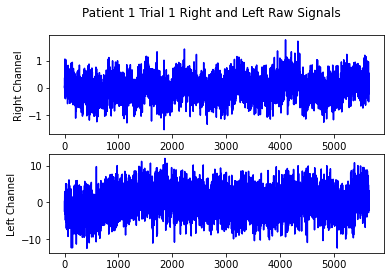

In [66]:
#Patient 1 Run 1, Obtaining 2 HbO Channels (Left and Right of Brain)

#Right Channel HbO Signal
assert(is_hbo[8])== True #Make sure we are choosing a HbO signal (Oxygenated Hemoglobin)
assert(snirf.get_data().shape)==(4412,5653) #4412 channels by 5653 signal points per channel
snirf_d=snirf.get_data()
d=snirf_d[8,:] #Extract the 8th channel signal
fig, axs = plt.subplots(2)
fig.suptitle('Patient 1 Trial 1 Right and Left Raw Signals')
axs[0].plot(d,color="blue",label="Right")
axs[0].set_ylabel("Right Channel")

#Left Channel HbO Signal
assert(is_hbo[4380])== True #Make sure we are choosing a HbO signal (Oxygenated Hemoglobin)
f=snirf_d[4380,:] #Extract the 4380th channel signal
axs[1].plot(f,color="blue",label="Left")
axs[1].set_ylabel("Left Channel")

Text(0, 0.5, 'Left Channel')

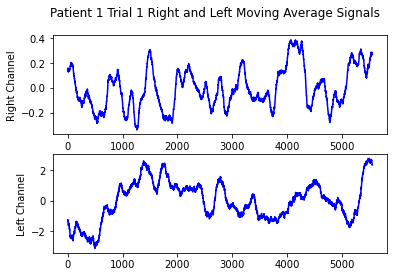

In [67]:
#Apply Moving Average to the data
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    return np.convolve(np.squeeze(values), weights, 'valid')

fig, axs = plt.subplots(2)
fig.suptitle('Patient 1 Trial 1 Right and Left Moving Average Signals')
axs[0].plot(movingaverage(d, 100),color="blue",label="Right")
axs[0].set_ylabel("Right Channel")

#Left Channel HbO Signal
assert(is_hbo[4380])== True #Make sure we are choosing a HbO signal (Oxygenated Hemoglobin)
f=snirf_d[4380,:] #Extract the 8th channel signal
axs[1].plot(movingaverage(f, 100),color="blue",label="Left")
axs[1].set_ylabel("Left Channel")

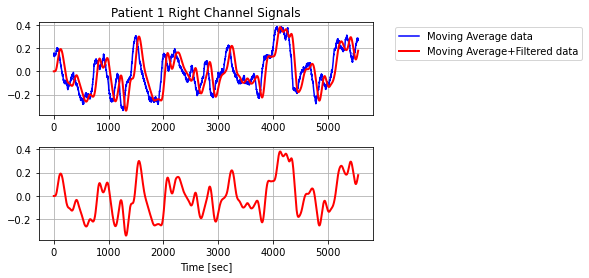

In [68]:
# Filter Setup
T = 800         # value taken in seconds
t = np.linspace(0, T, 5653, endpoint=False)

# Filtering and plotting
p1_rf = butter_lowpass_filter(movingaverage(d,100), cutoff, fs, order) #patient 1 right filtered signal
plt.subplot(2, 1, 1)
plt.title("Patient 1 Right Channel Signals")
plt.plot(movingaverage(d,100), 'b-', label='Moving Average data')
plt.plot(p1_rf, 'r-', linewidth=2, label='Moving Average+Filtered data')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.subplot(2, 1, 2)
plt.plot(p1_rf, 'r-', linewidth=2, label='Moving Average+Filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.subplots_adjust(hspace=0.35)

Text(0.5, 0, 'Time [sec]')

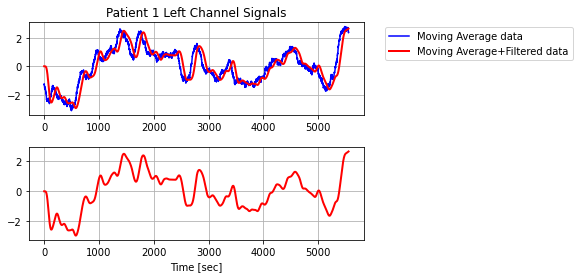

In [69]:
# Filtering and plotting
p1_lf = butter_lowpass_filter(movingaverage(f,100), cutoff, fs, order) #patient 1 left filtered signal
plt.subplot(2, 1, 1)
plt.plot(movingaverage(f,100), 'b-', label='Moving Average data')
plt.plot(p1_lf, 'r-', linewidth=2,label='Moving Average+Filtered data')
plt.title("Patient 1 Left Channel Signals")
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.subplot(2, 1, 2)
plt.plot(p1_lf, 'r-', linewidth=2, label='Moving Average+Filtered data')
plt.grid()
plt.subplots_adjust(hspace=0.35)
plt.xlabel('Time [sec]')

In [70]:
print(p1_lf.shape)
print(movingaverage(f,100).shape)
print(f.shape)
print(snirf.times.shape)
print(movingaverage(snirf.times,100).shape)

(5554,)
(5554,)
(5653,)
(5653,)
(5554,)


In [71]:
#Read in Test DataSet
path = "157dcb4-Hb_Moments.snirf" #Patient 1 Run 1 data
snirf_test = read_raw_snirf(path)

channel_names_test = [z['ch_name'] for z in snirf.info['chs']]
is_hbo_test = np.array([1 if channel_name.endswith('hbo') else 0 for channel_name in channel_names_test], dtype=bool)
channel_locations_3d_test = [z['loc'][:3] for z in snirf_test.info['chs']] 

Loading /Users/soulaimanebentaleb/mne-python/157dcb4-Hb_Moments.snirf


Text(0, 0.5, 'Left Channel')

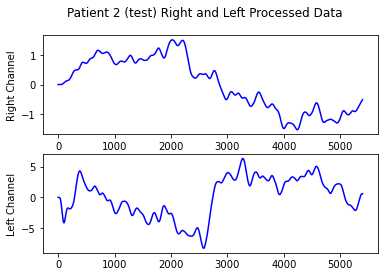

In [72]:
#Right Channel HbO Signal
assert(is_hbo_test[8])== True #Make sure we are choosing a HbO signal (Oxygenated Hemoglobin)
snirf_t=snirf_test.get_data()
test_r=snirf_t[8,:] #Extract the 9th channel signal

#Left Channel HbO Signal
assert(is_hbo_test[152])== True #Make sure we are choosing a HbO signal (Oxygenated Hemoglobin)
test_l=snirf_t[152,:] #Extract the 151th channel signal 

#Apply Moving Average and Filter
p_test_r=butter_lowpass_filter(movingaverage(test_r,100), cutoff, fs, order)
p_test_l=butter_lowpass_filter(movingaverage(test_l,100), cutoff, fs, order)

#Plot
fig, axs = plt.subplots(2)
fig.suptitle('Patient 2 (test) Right and Left Processed Data')
axs[0].plot(p_test_r,color="blue",label="Right")
axs[0].set_ylabel("Right Channel")

#Left Channel HbO Signal
axs[1].plot(p_test_l,color="blue",label="Left")
axs[1].set_ylabel("Left Channel")

In [73]:
print(snirf_test.times.shape)
print(snirf.times.shape) #Our timestamps are different for training and testing data

(5493,)
(5653,)


## Logistic Regression Initial Model

#### Sara's code

In [74]:
#Logistic Regression Model 1 (right channel data)

#Set Inputs
x1=p1_lf.reshape(-1,1) #left channel
x2=p1_rf.reshape(-1,1) #right channel

#Make the Model
model_r = LogisticRegression(solver='liblinear',random_state=0)

#Fit the Model
model_r.fit(x2,blocks) #Blocks is y_train

#Model Attributes
print("Our Labels Are:",model_r.classes_)
print("Our Models Intercept is:", model_r.intercept_)
print("Our Models Coefficients are:",model_r.coef_)

#Evaluate Model's Performance on Test Dataset
display(pd.DataFrame(model_r.predict_proba(p_test_r.reshape(-1,1)),columns=['Right Tap(0) ','Left Tap(1)']))
display(pd.DataFrame(model_r.predict(p_test_r.reshape(-1,1)),columns=['Model Prediction']))
y_pred=model_r.predict(p_test_r.reshape(-1,1)) #Predict tapping for test dataset
print("Accuracy:",accuracy_score(y_test, y_pred)) #Accuracy on Completely New Dataset
print("Precision:",precision_score(y_test, y_pred,average='weighted'))
print("Recall:",recall_score(y_test, y_pred,average='weighted'))

#Cross Validation Score for l1 Penalty
scores = cross_val_score(model_r,x2,blocks,cv=20)
print("Cross Validation prediction error for liblinear solver with a l2 penalty is",scores.mean())

Our Labels Are: [0. 1.]
Our Models Intercept is: [-1.23306255]
Our Models Coefficients are: [[-1.15474909]]


,Right Tap(0),Left Tap(1)
0,0.774354,0.225646
1,0.774354,0.225646
2,0.774354,0.225646
3,0.774354,0.225646
4,0.774354,0.225646
...,...,...
5389,0.651062,0.348938
5390,0.651878,0.348122
5391,0.652693,0.347307
5392,0.653507,0.346493


,Model Prediction
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
5389,0.0
5390,0.0
5391,0.0
5392,0.0


Accuracy: 0.6453466814979607
Precision: 0.5871513926712951
Recall: 0.6453466814979607
Cross Validation prediction error for liblinear solver with a l2 penalty is 0.7716970106225489


In [75]:
#Logistic Regression Model 1 (right channel data)

#Set Inputs
x1=p1_lf.reshape(-1,1) #left channel
x2=p1_rf.reshape(-1,1) #right channel

#Make the Model
model_r = LogisticRegression(solver='liblinear',random_state=0)

#Fit the Model
model_r.fit(x2,blocks) #Blocks is y_train

#Model Attributes
print("Our Labels Are:",model_r.classes_)
print("Our Models Intercept is:", model_r.intercept_)
print("Our Models Coefficients are:",model_r.coef_)

#Evaluate Model's Performance on Test Dataset
display(pd.DataFrame(model_r.predict_proba(p_test_r.reshape(-1,1)),columns=['Right Tap(0) ','Left Tap(1)']))
display(pd.DataFrame(model_r.predict(p_test_r.reshape(-1,1)),columns=['Model Prediction']))
y_pred=model_r.predict(p_test_r.reshape(-1,1)) #Predict tapping for test dataset
print("Accuracy:",accuracy_score(y_test, y_pred)) #Accuracy on Completely New Dataset
print("Precision:",precision_score(y_test, y_pred,average='weighted'))
print("Recall:",recall_score(y_test, y_pred,average='weighted'))

#Cross Validation Score for l1 Penalty
scores = cross_val_score(model_r,x2,blocks,cv=20)
print("Cross Validation prediction error for liblinear solver with a l2 penalty is",scores.mean())

Our Labels Are: [0. 1.]
Our Models Intercept is: [-1.23306255]
Our Models Coefficients are: [[-1.15474909]]


,Right Tap(0),Left Tap(1)
0,0.774354,0.225646
1,0.774354,0.225646
2,0.774354,0.225646
3,0.774354,0.225646
4,0.774354,0.225646
...,...,...
5389,0.651062,0.348938
5390,0.651878,0.348122
5391,0.652693,0.347307
5392,0.653507,0.346493


,Model Prediction
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
5389,0.0
5390,0.0
5391,0.0
5392,0.0


Accuracy: 0.6453466814979607
Precision: 0.5871513926712951
Recall: 0.6453466814979607
Cross Validation prediction error for liblinear solver with a l2 penalty is 0.7716970106225489


In [76]:
# print(y_test.shape)
# print(y_pred.shape)
# print(y_pred)
# for i in range(len(y_pred)):
#     if y_pred[i]==1:
#         print("Found A 1 Prediction")

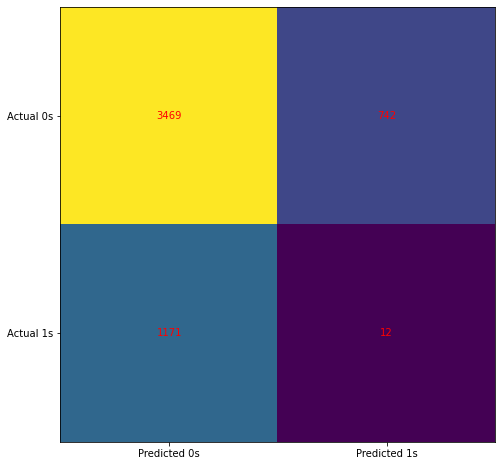

In [77]:
#More Evaluation Metrics
cm = confusion_matrix(y_test,y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

## Hyperparameter Tuning Using Cross Validation

In [80]:
# Regularization penalty optimization
p=np.array(['l1','elasticnet']) #penalty array
s=np.array(['liblinear','saga']) #solver array
r=np.array([None,0.8])
Q2Y_p=np.empty(2)#Variable to store my Q2Y values in

for i in range(2):
    skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=1,)
    y_true, y_pred = np.zeros(5554), np.zeros(5554)

    for train_index, test_index in skf.split(x2,blocks):
        X_train, X_test = x2[train_index], x2[test_index]
        y_train, y_test = blocks[train_index], blocks[test_index]
     
        #Create Linear Regression model with varying solver and associated penalty
        model_r = LogisticRegression(penalty=p[i],solver=s[i],l1_ratio=r[i],random_state=0)

        #Fit the Model to training set
        model_r.fit(x2[train_index],blocks[train_index]) #Blocks is y_train

        #Predict Tapping 
        pred=model_r.predict(x2[test_index]) 
    
        #Store predicted vs true values
        y_true[test_index]=y_test
        y_pred[test_index]=pred #Storing our tapping predictions
    
    print("Accuracy for", s[i],"solver with a",p[i],"penalty is:",accuracy_score(y_true, y_pred))
    print("Precision for",s[i],"solver with a",p[i],"penalty is:",precision_score(y_true, y_pred,average='weighted'))
    print("Recall for", s[i],"solver with a",p[i],"penalty is:", recall_score(y_true, y_pred,average='weighted'))
    
    #Calculate Q2Y value for Value and Store in Array
    corr_matrix = np.corrcoef(y_true, y_pred)
    corr = corr_matrix[0,1]
    Q2Y_p[i] = corr**2 
    print("Q2Y Value for", s[i],"solver with a",p[i],"penalty is",Q2Y_p[i])

Accuracy for liblinear solver with a l1 penalty is: 0.7716960749009723
Precision for liblinear solver with a l1 penalty is: 0.595514832017567
Recall for liblinear solver with a l1 penalty is: 0.7716960749009723
Q2Y Value for liblinear solver with a l1 penalty is nan
Accuracy for saga solver with a elasticnet penalty is: 0.7716960749009723
Precision for saga solver with a elasticnet penalty is: 0.595514832017567
Recall for saga solver with a elasticnet penalty is: 0.7716960749009723
Q2Y Value for saga solver with a elasticnet penalty is nan


In [81]:
# Regularization penalty optimization

#Easier Way to Perform Cross Validation
from sklearn.model_selection import cross_val_score
for i in range(2):
    clf = LogisticRegression(penalty=p[i],solver=s[i],l1_ratio=r[i],random_state=0)
    scores = cross_val_score(clf, x2,blocks , cv=20)
    print("Accuracy Value for", s[i],"solver with a",p[i],"penalty is",scores.mean())

Accuracy Value for liblinear solver with a l1 penalty is 0.7716970106225489
Accuracy Value for saga solver with a elasticnet penalty is 0.7716970106225489


No significant change in accuracy was observed when we changed the regularization penalty from l2 (defualt) to l1 and elasticnet. 

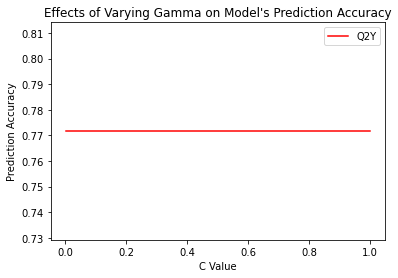

In [82]:
# C parameter optimization
c=np.logspace(-3,0,num=20)
ac=np.empty(20)

for i in range(20):
    clf = LogisticRegression(solver='liblinear',C=c[i],random_state=0)
    score = cross_val_score(clf, x2,blocks , cv=20)
    ac[i]=score.mean()
#Plot Accuracy as a Function of Varying C values
plt.plot(c,ac,'r-',label="Q2Y")
#plt.plot(a,p,'b-',label="R2Y")
plt.xlabel("C Value")
plt.ylabel("Prediction Accuracy")
plt.title("Effects of Varying Gamma on Model's Prediction Accuracy")
plt.legend()

We observe that there is no effect of varying C value on the model's ability to predict.

https://realpython.com/logistic-regression-python/

#### Souli's code

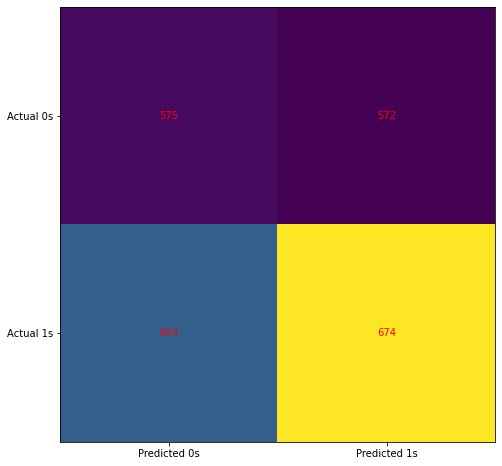

Our logistic regression model's accuracy for patient 1 is 0.5152640264026402.
Our logistic regression model's mean accuracy is 0.5717783899602081.


In [83]:
#Patient 2
#10-Fold Cross Validation
CV_predicted_Y_array_reg = []
Y_test_array_reg = []

kf = KFold(n_splits=10)
for train_index, test_index in kf.split(filt_right_left_data.T):
    X_train, X_test = filt_right_left_data.T[train_index], filt_right_left_data.T[test_index]
    Y_train, Y_test = filt_right_left_labels[train_index], filt_right_left_labels[test_index]
    Y_test_array_reg.append(Y_test)
    reg = LogisticRegression(solver='liblinear',random_state=0)
    reg.fit(X_train, Y_train)
    CV_predicted_Y_array_reg.append(reg.predict(X_test))
    
Y_test_total_reg=[]

for i in range(len(Y_test_array_reg)):
    for s in range(len(Y_test_array_reg[i])):
        Y_test_total_reg.append(Y_test_array_reg[i][s])
        
CV_predicted_Y_total_reg=[]

for i in range(len(CV_predicted_Y_array_reg)):
    for s in range(len(CV_predicted_Y_array_reg[i])):
        CV_predicted_Y_total_reg.append(CV_predicted_Y_array_reg[i][s])
                
#SVM Confusion Matrix
cm = confusion_matrix(Y_test_total_reg,CV_predicted_Y_total_reg)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

print("Our logistic regression model's accuracy for patient 1 is " + str(accuracy_score(Y_test_total_reg,CV_predicted_Y_total_reg)) + ".")
CV_accuracy_reg=cross_val_score(SVC(kernel='rbf'), filt_right_left_data.T, filt_right_left_labels, cv=10).mean()
print("Our logistic regression model's mean accuracy is " + str(CV_accuracy_reg) + ".")

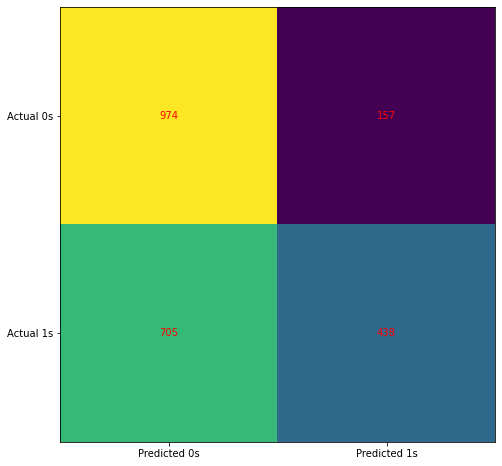

Our logistic regression model's accuracy for patient 2 is 0.6209322779243623.
Our logistic regression model's mean accuracy is 0.6969549424221346.


In [84]:
#Patient 2
#10-Fold Cross Validation
CV_predicted_Y_array_reg_2 = []
Y_test_array_reg_2 = []

kf = KFold(n_splits=10)
for train_index, test_index in kf.split(filt_right_left_data_2.T):
    X_train, X_test = filt_right_left_data_2.T[train_index], filt_right_left_data_2.T[test_index]
    Y_train, Y_test = filt_right_left_labels_2[train_index], filt_right_left_labels_2[test_index]
    Y_test_array_reg_2.append(Y_test)
    reg = LogisticRegression(solver='liblinear',random_state=0)
    reg.fit(X_train, Y_train)
    CV_predicted_Y_array_reg_2.append(reg.predict(X_test))
    
Y_test_total_reg_2=[]

for i in range(len(Y_test_array_reg_2)):
    for s in range(len(Y_test_array_reg_2[i])):
        Y_test_total_reg_2.append(Y_test_array_reg_2[i][s])
        
CV_predicted_Y_total_reg_2=[]

for i in range(len(CV_predicted_Y_array_reg_2)):
    for s in range(len(CV_predicted_Y_array_reg_2[i])):
        CV_predicted_Y_total_reg_2.append(CV_predicted_Y_array_reg_2[i][s])
                
#SVM Confusion Matrix
cm = confusion_matrix(Y_test_total_reg_2,CV_predicted_Y_total_reg_2)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

print("Our logistic regression model's accuracy for patient 2 is " + str(accuracy_score(Y_test_total_reg_2,CV_predicted_Y_total_reg_2)) + ".")
CV_accuracy_reg_2=cross_val_score(SVC(kernel='rbf'), filt_right_left_data_2.T, filt_right_left_labels_2, cv=10).mean()
print("Our logistic regression model's mean accuracy is " + str(CV_accuracy_reg_2) + ".")

## PLS-DA Model

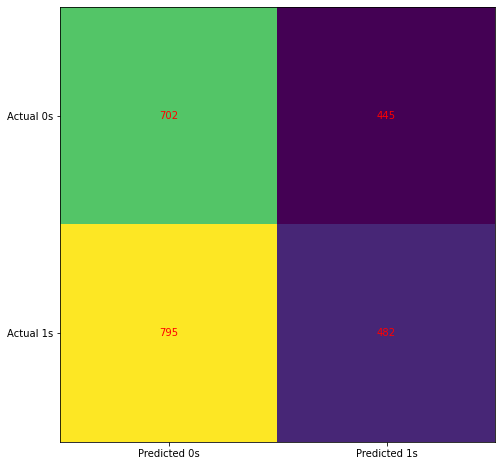

Our PLSR model's accuracy for patient 1 is 0.4884488448844885.
Our PLSR model's mean accuracy is -0.6450198723441151.


In [85]:
#Patient 1 Run 1
#10-Fold Cross Validation
CV_predicted_Y_array_plsr = []
Y_test_array_plsr = []

kf = KFold(n_splits=10)
for train_index, test_index in kf.split(filt_right_left_data.T):
    X_train, X_test = filt_right_left_data.T[train_index], filt_right_left_data.T[test_index]
    Y_train, Y_test = filt_right_left_labels[train_index], filt_right_left_labels[test_index]
    Y_test_array_plsr.append(Y_test)
    plsr=PLSRegression(n_components=2)
    plsr.fit(X_train, Y_train)
    CV_predicted_Y_array_plsr.append(plsr.predict(X_test))
    
Y_test_total_plsr=[]

for i in range(len(Y_test_array_plsr)):
    for s in range(len(Y_test_array_plsr[i])):
        Y_test_total_plsr.append(Y_test_array_plsr[i][s])
        
CV_predicted_Y_total_plsr=[]

for i in range(len(CV_predicted_Y_array_plsr)):
    for s in range(len(CV_predicted_Y_array_plsr[i])):
        CV_predicted_Y_total_plsr.append(CV_predicted_Y_array_plsr[i][s])
        
CV_predicted_Y_plsr=[]

for i in CV_predicted_Y_total_plsr:
    if i>=0.5:
        CV_predicted_Y_plsr.append(1)
    else:
        CV_predicted_Y_plsr.append(0)
        
assert len(CV_predicted_Y_plsr)==len(CV_predicted_Y_total_plsr)
        
#PLSR Confusion Matrix
cm = confusion_matrix(Y_test_total_plsr,CV_predicted_Y_plsr)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

print("Our PLSR model's accuracy for patient 1 is " + str(accuracy_score(Y_test_total_plsr,CV_predicted_Y_plsr)) + ".")
CV_accuracy_plsr=cross_val_score(PLSRegression(n_components=2), filt_right_left_data.T, filt_right_left_labels, cv=10).mean()
print("Our PLSR model's mean accuracy is " + str(CV_accuracy_plsr) + ".")

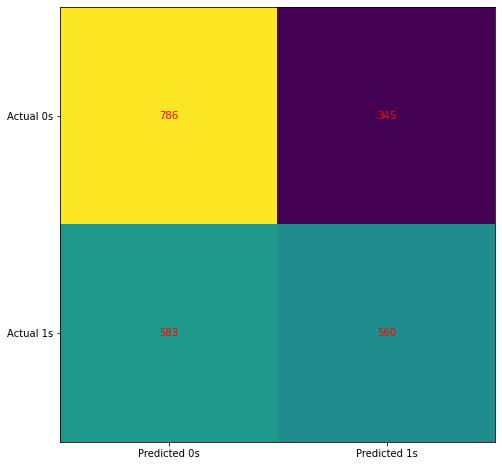

Our PLSR model's accuracy for patient 2 is 0.5919085312225154.
Our PLSR model's mean accuracy is -0.06770567406870567.


In [86]:
#Patient 2
#10-Fold Cross Validation
CV_predicted_Y_array_plsr_2 = []
Y_test_array_plsr_2 = []

kf = KFold(n_splits=10)
for train_index, test_index in kf.split(filt_right_left_data_2.T):
    X_train, X_test = filt_right_left_data_2.T[train_index], filt_right_left_data_2.T[test_index]
    Y_train, Y_test = filt_right_left_labels_2[train_index], filt_right_left_labels_2[test_index]
    Y_test_array_plsr_2.append(Y_test)
    plsr=PLSRegression(n_components=2)
    plsr.fit(X_train, Y_train)
    CV_predicted_Y_array_plsr_2.append(plsr.predict(X_test))
    
Y_test_total_plsr_2=[]

for i in range(len(Y_test_array_plsr_2)):
    for s in range(len(Y_test_array_plsr_2[i])):
        Y_test_total_plsr_2.append(Y_test_array_plsr_2[i][s])
        
CV_predicted_Y_total_plsr_2=[]

for i in range(len(CV_predicted_Y_array_plsr_2)):
    for s in range(len(CV_predicted_Y_array_plsr_2[i])):
        CV_predicted_Y_total_plsr_2.append(CV_predicted_Y_array_plsr_2[i][s])
        
CV_predicted_Y_plsr_2=[]

for i in CV_predicted_Y_total_plsr_2:
    if i>=0.5:
        CV_predicted_Y_plsr_2.append(1)
    else:
        CV_predicted_Y_plsr_2.append(0)
        
assert len(CV_predicted_Y_plsr_2)==len(CV_predicted_Y_total_plsr_2)
        
#PLSR Confusion Matrix
cm = confusion_matrix(Y_test_total_plsr_2,CV_predicted_Y_plsr_2)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

print("Our PLSR model's accuracy for patient 2 is " + str(accuracy_score(Y_test_total_plsr_2,CV_predicted_Y_plsr_2)) + ".")
CV_accuracy_plsr_2=cross_val_score(PLSRegression(n_components=2), filt_right_left_data_2.T, filt_right_left_labels_2, cv=10).mean()
print("Our PLSR model's mean accuracy is " + str(CV_accuracy_plsr_2) + ".")

## SVM Model

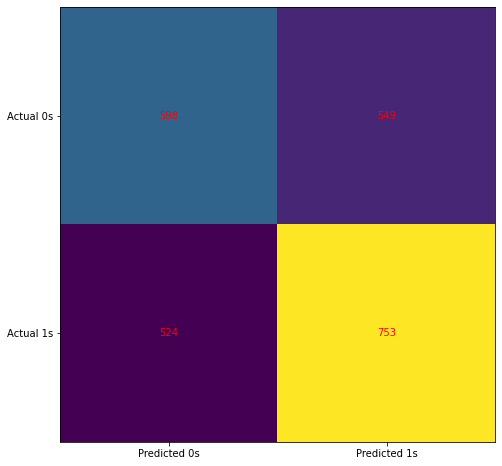

Our SVM rbf model's accuracy for patient 1 is 0.5573432343234324.
Our SVM linear model's mean accuracy is 0.5717783899602081.


In [87]:
#Patient 1 Run 1
#10-Fold Cross Validation
CV_predicted_Y_array_svm = []
Y_test_array_svm = []

kf = KFold(n_splits=10)
for train_index, test_index in kf.split(filt_right_left_data.T):
    X_train, X_test = filt_right_left_data.T[train_index], filt_right_left_data.T[test_index]
    Y_train, Y_test = filt_right_left_labels[train_index], filt_right_left_labels[test_index]
    Y_test_array_svm.append(Y_test)
    svm=SVC(kernel='rbf')
    svm.fit(X_train, Y_train)
    CV_predicted_Y_array_svm.append(svm.predict(X_test))
    
Y_test_total_svm=[]

for i in range(len(Y_test_array_svm)):
    for s in range(len(Y_test_array_svm[i])):
        Y_test_total_svm.append(Y_test_array_svm[i][s])
        
CV_predicted_Y_total_svm=[]

for i in range(len(CV_predicted_Y_array_svm)):
    for s in range(len(CV_predicted_Y_array_svm[i])):
        CV_predicted_Y_total_svm.append(CV_predicted_Y_array_svm[i][s])
                
#SVM Confusion Matrix
cm = confusion_matrix(Y_test_total_svm,CV_predicted_Y_total_svm)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

print("Our SVM rbf model's accuracy for patient 1 is " + str(accuracy_score(Y_test_total_svm,CV_predicted_Y_total_svm)) + ".")
CV_accuracy_svm=cross_val_score(SVC(kernel='rbf'), filt_right_left_data.T, filt_right_left_labels, cv=10).mean()
print("Our SVM linear model's mean accuracy is " + str(CV_accuracy_svm) + ".")

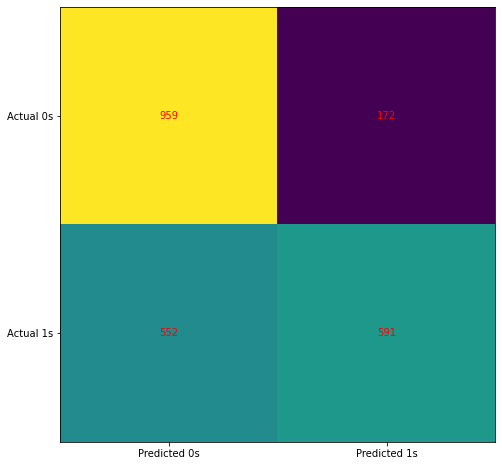

Our SVM rbf model's accuracy for patient 2 is 0.6816182937554969.
Our SVM linear model's mean accuracy is 0.6969549424221346.


In [88]:
#Patient 2
#10-Fold Cross Validation
CV_predicted_Y_array_svm_2 = []
Y_test_array_svm_2 = []

kf = KFold(n_splits=10)
for train_index, test_index in kf.split(filt_right_left_data_2.T):
    X_train, X_test = filt_right_left_data_2.T[train_index], filt_right_left_data_2.T[test_index]
    Y_train, Y_test = filt_right_left_labels_2[train_index], filt_right_left_labels_2[test_index]
    Y_test_array_svm_2.append(Y_test)
    svm=SVC(kernel='rbf')
    svm.fit(X_train, Y_train)
    CV_predicted_Y_array_svm_2.append(svm.predict(X_test))
    
Y_test_total_svm_2=[]

for i in range(len(Y_test_array_svm_2)):
    for s in range(len(Y_test_array_svm_2[i])):
        Y_test_total_svm_2.append(Y_test_array_svm_2[i][s])
        
CV_predicted_Y_total_svm_2=[]

for i in range(len(CV_predicted_Y_array_svm_2)):
    for s in range(len(CV_predicted_Y_array_svm_2[i])):
        CV_predicted_Y_total_svm_2.append(CV_predicted_Y_array_svm_2[i][s])
                
#SVM Confusion Matrix
cm = confusion_matrix(Y_test_total_svm_2,CV_predicted_Y_total_svm_2)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

print("Our SVM rbf model's accuracy for patient 2 is " + str(accuracy_score(Y_test_total_svm_2,CV_predicted_Y_total_svm_2)) + ".")
CV_accuracy_svm_2=cross_val_score(SVC(kernel='rbf'), filt_right_left_data_2.T, filt_right_left_labels_2, cv=10).mean()
print("Our SVM linear model's mean accuracy is " + str(CV_accuracy_svm_2) + ".")